In [1]:
import io
import re
import itertools

import geojson

import pandas
import numpy as np
from shapely.geometry import LineString

import itertools
import more_itertools
# import tqdm
from tqdm.notebook import tqdm
import netCDF4


In [2]:
def simplify_transect(coordinates,tol=1.0):
    c = list(zip(*coordinates))
    y = c[2]
    x = range(len(y))
    ls = LineString(list(zip(x,y))).simplify(tol,preserve_topology=False)
    coordinates_s = list(zip(*
                             [np.array(c[0])[np.array(ls.xy[0].tolist()).astype(int)].tolist(),
                             np.array(c[1])[np.array(ls.xy[0].tolist()).astype(int)].tolist(),
                             [int(lls) for lls in ls.xy[1].tolist()]]
                            ))
    return coordinates_s

In [3]:
#ds = netCDF4.Dataset('http://opendap.deltares.nl/thredds/dodsC/opendap/rijkswaterstaat/jarkus/profiles/transect_r20240117.nc')
ds = netCDF4.Dataset(r'C:\Users\fuentesm\Marilu\Deltares\Projects\Coastviewer\jarkus\scripts\transect_r20240405.nc')

ids = ds.variables['id'][:]
times = ds.variables['time'][:]

In [4]:
#id_ = 7003900

def transect2features(id_, t_):
    transect_idx = np.searchsorted(ids, id_)
    time_idx = np.searchsorted(times, t_)

    variables = {
        'lat': {"var": 'lat', "slice": np.s_[transect_idx, :]},
        'lon': {"var": 'lon', "slice": np.s_[transect_idx, :]},
        'z': {"var": 'altitude', "slice": np.s_[time_idx, transect_idx, :]},
        't': {"var": 'time', "slice": np.s_[time_idx]}
        
    }
    data = {}
    for var, props in variables.items():
        data[var] = ds.variables[props['var']][props['slice']]

    for rr, row in enumerate(data['z']):
        #if rr%50==0:
        #    print(str(rr)+ ' out of '+ str(len(data['z'])))
        # get coordinates from df and convert to a max of 5digits, and give z as cm
        coords = pandas.DataFrame(data=dict(
            lon=[float("%.5f" % xx) for xx in data['lon'][rr]], 
            lat=[float("%.5f" % yy) for yy in data['lat'][rr]],
            z=[int("%.0f" %(zz*100)) if not np.ma.is_masked(zz) else np.NaN for zz in row ]
        ))

        coordinates = coords.dropna().values.tolist()
        
        if not coordinates:
            continue
        # simplify geometry
        coordinates_s = simplify_transect(coordinates)
        # print(coordinates)
        
        geometry = geojson.LineString(coordinates=coordinates_s)
        date = netCDF4.num2date(data['t'], ds.variables['time'].units)
        properties = {} #"date": date.isoformat(), #"year": date.year
        
        yield geojson.Feature(id="{}-{}".format(id_[rr], date.year), geometry=geometry, properties=properties)


In [5]:
for t_ in tqdm(times[:]):
    features = []
    id_ = ids
    features.extend(transect2features(id_,t_))
    
    for i, chunk in enumerate(more_itertools.chunked(features, 10000)):
        collection = geojson.FeatureCollection(chunk)
    
    year = netCDF4.num2date(t_,units=ds.variables['time'].units).year
    with open('jarkus_{:d}.json'.format(year), 'w') as f:
        geojson.dump(collection, f)

  0%|          | 0/59 [00:00<?, ?it/s]

In [6]:
# for t_ in tqdm.tqdm_notebook(times[:]):
#     features = []
#     id_ = ids
#     features.extend(transect2features(id_,t_))
    
#     for i, chunk in enumerate(more_itertools.chunked(features, 10000)):
#         collection = geojson.FeatureCollection(chunk)
    
#     year = netCDF4.num2date(t_,units=ds.variables['time'].units).year
#     with open('jarkus_{:d}.json'.format(year), 'w') as f:
#         geojson.dump(collection, f)

In [7]:
# snippet for test
features = []
id_ = [7003900]
t_ = times[0]
features.extend(transect2features(id_,t_))
for i, chunk in enumerate(more_itertools.chunked(features, 10000)):
        collection = geojson.FeatureCollection(chunk)
with open('jarkus_test.json', 'w') as f:
        g=geojson.dump(collection, f)

34
24
24


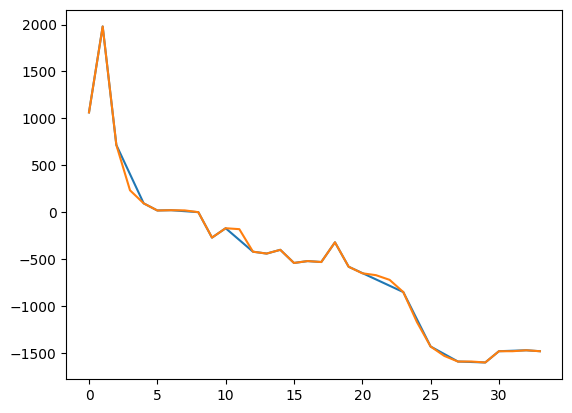

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

C = list(zip(*collection["features"][0]["geometry"]["coordinates"]))
print(len(C[2]))

ll = LineString(list(zip(range(len(C[2])),C[2])))
ls = ll.simplify(1,preserve_topology=False)
print(len(ls.xy[0].tolist()))

plt.plot(ls.xy[0].tolist(),ls.xy[1].tolist())
plt.plot(range(len(C[2])),C[2])
print(len(ls.xy[0].tolist()))